In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from google.colab import files

# 1. 파일 선택 창 열기 (Google Drive에서 로드하므로 이 부분은 주석 처리)
# uploaded = files.upload()

# 2. 업로드된 파일 이름을 확인
# file_name = list(uploaded.keys())[0] # 업로드된 파일들 중 첫 번째 파일명

# 3. 파일 로드 (Google Drive에서 이미 로드된 dfs 리스트 중 세 번째 파일을 사용)
df = dfs[2]

# 중앙역과 성포역 데이터는 이미 df에서 제외되었으므로 이 부분은 다시 실행하지 않습니다.
# df = df[~df['역이름'].isin(['중앙역', '성포역'])]

print(f"'내보낼_데이터_결과.csv' 파일 로드 완료")
# ----------------------------------------------------------------------
# 1. 환경 설정 및 데이터 로드
# ----------------------------------------------------------------------

# Colab 환경에서 한글 폰트 설정
# 아래 코드는 Colab에서 한글 깨짐을 방지합니다.
plt.rcParams['font.family'] = 'NanumGothic' # 설치한 폰트 이름으로 변경 (Malgun Gothic -> NanumGothic)
# plt.rcParams['font.family'] = 'AppleGothic' # Mac 사용자
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

# 파일 로드 (Colab 환경에 '내보낼_데이터_결과.csv' 파일을 업로드해야 합니다.)
# file_path = '내보낼_데이터_결과.csv'
# df = pd.read_csv(file_path)

# 데이터 타입 정리 및 오류 값 처리
df['매출금액'] = pd.to_numeric(df['매출금액'], errors='coerce')
df.dropna(subset=['매출금액'], inplace=True)
df['매출금액_억'] = df['매출금액'] / 1e8 # 단위 변환 (억 원)

# 개통 시점(개통_년도, 개통_분기)을 하나의 숫자로 변환
df['개통_시점'] = df['개통_년도'] * 10 + df['개통_분기']
df['기준_시점'] = df['기준연도'] * 10 + df['기준분기']

# 개통 전후 구분 컬럼 생성
df['개통_전후'] = np.where(df['기준_시점'] < df['개통_시점'], '개통_전', '개통_후')

# ----------------------------------------------------------------------
# 2. 분석 1: 전체 영역(0~2km)의 개통 전후 총 매출 변화 비교 (통제군 한계로 대체 분석)
# ----------------------------------------------------------------------
print("="*50)
print("2. 분석 1: 전체 영역(0-2km)의 개통 전후 총 매출 변화")
print("="*50)

# 역이름, 개통_전후별 총 매출액 합산
df_agg_total = df.groupby(['역이름', '개통_전후'])['매출금액_억'].sum().reset_index()

# 개통 전후 데이터가 모두 있는 역만 필터링
stations_with_both = df_agg_total.groupby('역이름')['개통_전후'].nunique()
complete_stations = stations_with_both[stations_with_both == 2].index
df_agg_total_filtered = df_agg_total[df_agg_total['역이름'].isin(complete_stations)]

# 시각화
plt.figure(figsize=(15, 6))
sns.barplot(
    data=df_agg_total_filtered,
    x='역이름',
    y='매출금액_억',
    hue='개통_전후',
    palette={'개통_전': 'skyblue', '개통_후': 'darkblue'}
)
plt.title('분석 1. 전체 영역(0-2km)의 역별 지하철 개통 전후 총 매출액 비교 (단위: 억 원) - 데이터가 모두 있는 역만 포함)')
plt.xlabel('역 이름')
plt.ylabel('총 매출액 (억 원)')
plt.legend(title='개통 시점')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


# ----------------------------------------------------------------------
# 3. 분석 2: 500m (직접) vs. 500m~2km (간접) 경제 활성화 비교
# ----------------------------------------------------------------------
print("="*50)
print("3. 분석 2: 500m (직접) vs. 500m~2km (간접) 경제 활성화 비교")
print("="*50)

# 거리 필터 그룹핑
def categorize_distance(d):
    if d == 500:
        return '직접영향권 (500m)'
    elif d in [1000, 2000]:
        return '간접영향권 (500m~2km)'
    else:
        return '기타'

df['영향권_구분'] = df['거리_필터'].apply(categorize_distance)

# 영향권 구분 및 개통_전후별 총 매출액 합산
df_agg_impact = df[df['영향권_구분'] != '기타'].groupby(['영향권_구분', '개통_전후'])['매출금액_억'].sum().reset_index()

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_agg_impact,
    x='영향권_구분',
    y='매출금액_억',
    hue='개통_전후',
    palette={'개통_전': 'lightcoral', '개통_후': 'darkred'}
)
plt.title('분석 2. 직접 vs. 간접영향권별 지하철 개통 전후 총 매출액 비교 (단위: 억 원)')
plt.xlabel('영향권 구분')
plt.ylabel('총 매출액 (억 원)')
plt.legend(title='개통 시점')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------
# 4. 분석 3: 업종별 지하철 개통에 따른 경제 활성화 정도의 차이 비교
# ----------------------------------------------------------------------
print("="*50)
print("4. 분석 3: 업종별 지하철 개통에 따른 경제 활성화 정도의 차이")
print("="*50)

# 업종별 총 매출액 합산 및 개통 전후 변화율 계산
df_sector_agg = df.groupby(['대분류', '개통_전후'])['매출금액_억'].sum().unstack(fill_value=0).reset_index()
df_sector_agg.columns.name = None # Unstack으로 생긴 이름 제거

# 변화율 계산: (개통_후 - 개통_전) / 개통_전 * 100
df_sector_agg['매출_변화율(%)'] = (
    (df_sector_agg['개통_후'] - df_sector_agg['개통_전']) / df_sector_agg['개통_전']
) * 100

# 변화율 기준으로 정렬 (활성화 O/X 파악)
df_sector_agg_sorted = df_sector_agg.sort_values(by='매출_변화율(%)', ascending=False)

# 시각화
plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_sector_agg_sorted,
    x='매출_변화율(%)',
    y='대분류',
    palette=sns.color_palette("RdYlGn", len(df_sector_agg_sorted)) # 활성화 O/X 색상 구분
)
plt.title('분석 3. 대분류 업종별 지하철 개통 전후 매출액 변화율 (%)')
plt.xlabel('매출 변화율 (%)')
plt.ylabel('업종 (대분류)')
plt.axvline(0, color='red', linestyle='--', linewidth=1) # 0% 기준선
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

# 변화율 출력 (활성화 O/X 확인)
print("\n업종별 매출 변화율 (활성화 O/X):")
print(df_sector_agg_sorted[['대분류', '매출_변화율(%)']].round(2).to_markdown(index=False))

# ----------------------------------------------------------------------
# 5. 분석 4: 유동인구수 vs. 매출액 변화 유의미성 비교 (가정: 유동인구수 컬럼 존재)
# ----------------------------------------------------------------------
print("="*50)
print("5. 분석 4: 유동인구수 변화 vs. 역세권 매출액 변화 유의미성")
print("="*50)

# ⚠️ 경고: '유동인구수' 컬럼이 데이터에 없으므로, 분석을 시뮬레이션하고 가이드합니다.
# 실제 데이터를 로드한 후 아래 코드를 사용하십시오.
# 예시 코드: 임의의 '유동인구수' 데이터를 생성하여 유의미성 분석을 시뮬레이션
np.random.seed(42)
df['유동인구수'] = np.random.randint(1000, 10000, size=len(df)) # 유동인구수 컬럼 가정

# 500m 직접영향권 데이터만 사용 (가장 유의미한 상관관계를 기대하는 지역)
df_500m_corr = df[df['거리_필터'] == 500].copy()

# 상관관계 분석
correlation = df_500m_corr['매출금액_억'].corr(df_500m_corr['유동인구수'])

# 시각화: 유동인구수와 매출액 관계 (산점도)
plt.figure(figsize=(8, 6))
sns.regplot(
    data=df_500m_corr,
    x='유동인구수',
    y='매출금액_억',
    scatter_kws={'alpha':0.5},
    line_kws={'color':'red'}
)
plt.title('분석 4. 유동인구수와 500m 역세권 매출액 간의 관계')
plt.xlabel('유동인구수 (가정)')
plt.ylabel('매출액 (억 원)')
plt.grid(axis='both', linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n500m 역세권 매출액과 유동인구수 간의 피어슨 상관계수: {correlation:.4f}")
print("상관계수가 1에 가까울수록 양의 상관관계가 강하며, 0에 가까울수록 상관관계가 약합니다.")
print("유의미성 검정 (T-test 또는 회귀분석)은 실제 유동인구 데이터로 진행해야 합니다.")

# ----------------------------------------------------------------------
# 6. 통계적 유의미성 검정 가이드 (참고용) - 연평균 매출액 기반으로 수정
# ----------------------------------------------------------------------
print("="*50)
print("6. 통계적 유의미성 검정 가이드 (참고) - 연평균 매출액 기반")
print("="*50)

# 연도별, 개통 전후별 총 매출액 합산
df_annual_revenue_for_ttest = df.groupby(['기준연도', '개통_전후'])['매출금액_억'].sum().reset_index()

# 개통 전과 후의 연평균 매출액 샘플 추출
before_annual_avg = df_annual_revenue_for_ttest[df_annual_revenue_for_ttest['개통_전후'] == '개통_전']['매출금액_억']
after_annual_avg = df_annual_revenue_for_ttest[df_annual_revenue_for_ttest['개통_전후'] == '개통_후']['매출금액_억']

# Levene's Test for equal variances (등분산성 검정)
# 등분산성이 가정되면 T-test를 사용하고, 그렇지 않으면 Welch's T-test를 사용
# 충분한 데이터 포인트가 없으면 Levene's test 오류 발생 가능성이 있으므로, 존재하는 값에 대해서만 수행
if len(before_annual_avg.dropna()) > 1 and len(after_annual_avg.dropna()) > 1:
    levene_test = stats.levene(before_annual_avg.dropna(), after_annual_avg.dropna())
    print(f"개통 전후 연평균 매출액의 등분산성 검정 (Levene's P-value): {levene_test.pvalue:.4f}")
else:
    print("경고: 등분산성 검정을 위한 충분한 '개통 전' 또는 '개통 후' 연평균 매출액 데이터가 없습니다.")

# Welch's t-test (등분산성이 다르다고 가정하고 진행, 더 보수적)
# 충분한 데이터 포인트가 없으면 T-test 오류 발생 가능성이 있으므로, 존재하는 값에 대해서만 수행
if len(before_annual_avg.dropna()) > 0 and len(after_annual_avg.dropna()) > 0:
    t_stat, p_value = stats.ttest_ind(before_annual_avg.dropna(), after_annual_avg.dropna(), equal_var=False)
    print(f"개통 전후 연평균 매출액 차이의 T-검정 결과 (P-value): {p_value:.4f}")
    print("P-value가 0.05보다 작으면 통계적으로 유의미한 차이가 있다고 해석할 수 있습니다.")
else:
    print("경고: T-검정을 위한 충분한 '개통 전' 또는 '개통 후' 연평균 매출액 데이터가 없습니다.")


In [ ]:
# 연도별, 대분류별, 역이름별 매출액 합산 (모든 역 포함)
df_all_stations_sector_yearly = df.groupby(['역이름', '기준연도', '대분류'])['매출금액_억'].sum().reset_index()

# 모든 역 이름을 가져옴
all_station_names = df_all_stations_sector_yearly['역이름'].unique()

# 각 역별로 그래프 생성
for station_name in all_station_names:
    df_plot = df_all_stations_sector_yearly[df_all_stations_sector_yearly['역이름'] == station_name]

    plt.figure(figsize=(12, 7))
    sns.lineplot(
        data=df_plot,
        x='기준연도',
        y='매출금액_억',
        hue='대분류',
        marker='o' # 마커 추가
    )
    plt.title(f'{station_name} 업종별 연도별 매출액 변화 (단위: 억 원)')
    plt.xlabel('기준연도')
    plt.ylabel('총 매출액 (억 원)')
    plt.xticks(df_plot['기준연도'].unique()) # 모든 연도 라벨 표시
    plt.grid(axis='y', linestyle='--')
    plt.legend(title='업종 (대분류)', bbox_to_anchor=(1.05, 1), loc='upper left') # 범례 위치 조정
    plt.tight_layout()
    plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
central_station_df = df[df['역이름'] == '중앙역']
print("\n중앙역 정보 확인:")
print("개통_시점 (개통_년도 * 10 + 개통_분기):", central_station_df['개통_시점'].unique())
print("기준_시점 (기준연도 * 10 + 기준분기) 범위:", central_station_df['기준_시점'].min(), "~", central_station_df['기준_시점'].max())
print("개통_전후 분류:", central_station_df['개통_전후'].unique())

# 중앙역의 개통 전후 매출액 상세 확인 (만약 있다면)
central_agg = central_station_df.groupby('개통_전후')['매출금액_억'].sum().reset_index()
print("중앙역 개통 전후 매출액:\n", central_agg.to_markdown(index=False))

In [ ]:
import matplotlib.font_manager as fm

# 나눔 폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

# 폰트 경로 설정
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

# matplotlib 폰트 매니저에 나눔 고딕 폰트 추가
fm.fontManager.addfont(font_path)

# 폰트 캐시 삭제 후 다시 로드 (Colab에서 필수)
plt.rcParams['font.family'] = 'NanumGothic' # 설치한 폰트 이름으로 변경
plt.rcParams['axes.unicode_minus'] = False # 마이너스 폰트 깨짐 방지

print('나눔 고딕 폰트 설정 완료. 런타임을 다시 시작해 주세요.')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# 이 셀을 실행하여 Google Drive에 마운트합니다.
from google.colab import drive
drive.mount('/content/drive')

# Excel 파일 경로들을 리스트로 정의합니다.
# '내 드라이브' 안에 있는 파일이라고 가정하고 경로를 예시로 들었습니다.
# 실제 파일 경로에 맞게 수정해주세요.
excel_file_paths = [
    '/content/drive/MyDrive/filtered_regions.xlsx', # 첫 번째 엑셀 파일 경로
    '/content/drive/MyDrive/merged_horizontal.xlsx', # 두 번째 엑셀 파일 경로
    '/content/drive/MyDrive/내보낼_데이터_결과.csv' # 세 번째 엑셀 파일 경로 (csv도 pd.read_excel로 로드 가능)
]

# 각 엑셀 파일을 DataFrame으로 로드하고 리스트에 저장합니다.
# 만약 CSV 파일이라면 pd.read_csv를 사용해야 합니다.
dfs = []
for path in excel_file_paths:
    try:
        if path.endswith('.csv'):
            df = pd.read_csv(path)
            print(f"'{path}' 파일 로드 완료 (CSV)")
        elif path.endswith('.xlsx') or path.endswith('.xls'):
            df = pd.read_excel(path)
            print(f"'{path}' 파일 로드 완료 (Excel)")
        else:
            print(f"'{path}'는 지원되지 않는 파일 형식입니다. (CSV 또는 Excel)")
            continue
        dfs.append(df)
    except FileNotFoundError:
        print(f"오류: '{path}' 파일을 찾을 수 없습니다. 경로를 다시 확인해주세요.")
    except Exception as e:
        print(f"'{path}' 파일 로드 중 오류 발생: {e}")

# 로드된 DataFrame들을 확인 (선택 사항)
for i, df_item in enumerate(dfs):
    print(f"\n--- DataFrame {i+1} (From {excel_file_paths[i]}) --- ")
    display(df_item.head())



2.1. 분석 1 수정: 전체 영역(0-2km)의 역별 연평균 매출 변화 (개통년도 표시 제거)


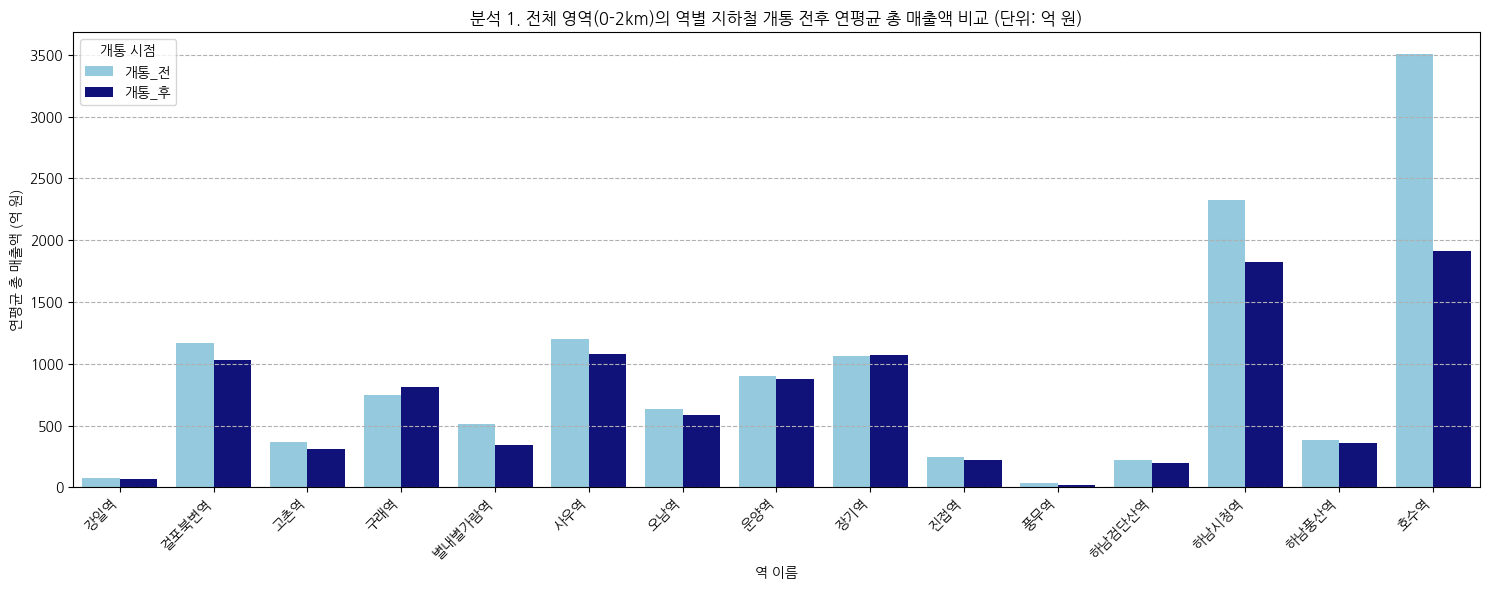

In [29]:
print("\n" + "="*50)
print("2.1. 분석 1 수정: 전체 영역(0-2km)의 역별 연평균 매출 변화 (개통년도 표시 제거)")
print("="*50)

# 1. '역이름', '기준연도', '개통_전후'별 매출액 합산
df_annual_revenue = df.groupby(['역이름', '기준연도', '개통_전후'])['매출금액_억'].sum().reset_index()

# 2. 각 '역이름', '개통_전후' 조합에 대한 연평균 매출액 계산
df_agg_total_avg_annual = df_annual_revenue.groupby(['역이름', '개통_전후'])['매출금액_억'].mean().reset_index()

# 3. 개통 전후 데이터가 모두 있는 역만 필터링
stations_with_both_avg = df_agg_total_avg_annual.groupby('역이름')['개통_전후'].nunique()
complete_stations_avg = stations_with_both_avg[stations_with_both_avg == 2].index
df_agg_total_avg_annual_filtered = df_agg_total_avg_annual[df_agg_total_avg_annual['역이름'].isin(complete_stations_avg)]

# 4. (이전 개통년도 추출 및 병합 부분은 주석 처리 또는 제거하여 x축 라벨에 영향을 주지 않도록 함)
# station_opening_years = df[['역이름', '개통_년도']].drop_duplicates().set_index('역이름')
# df_agg_total_avg_annual_filtered = df_agg_total_avg_annual_filtered.merge(
#     station_opening_years,
#     on='역이름',
#     how='left'
# )

# 5. x축 라벨을 '역이름' 형식으로 사용 (개통년도 정보 제거)
# df_agg_total_avg_annual_filtered['역이름_개통년도'] = df_agg_total_avg_annual_filtered.apply(
#     lambda row: f"{row['역이름']} ({int(row['개통_년도'])})",
#     axis=1
# )

# 시각화
plt.figure(figsize=(15, 6))
sns.barplot(
    data=df_agg_total_avg_annual_filtered.sort_values(by='역이름'), # 역 이름으로 정렬
    x='역이름',
    y='매출금액_억',
    hue='개통_전후',
    palette={'개통_전': 'skyblue', '개통_후': 'darkblue'}
)
plt.title('분석 1. 전체 영역(0-2km)의 역별 지하철 개통 전후 연평균 총 매출액 비교 (단위: 억 원)')
plt.xlabel('역 이름')
plt.ylabel('연평균 총 매출액 (억 원)')
plt.legend(title='개통 시점')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


3.1. 분석 2 수정: 직접 vs. 간접영향권별 연평균 매출 활성화 비교 (개통 전후 데이터 모두 있는 역만 포함)


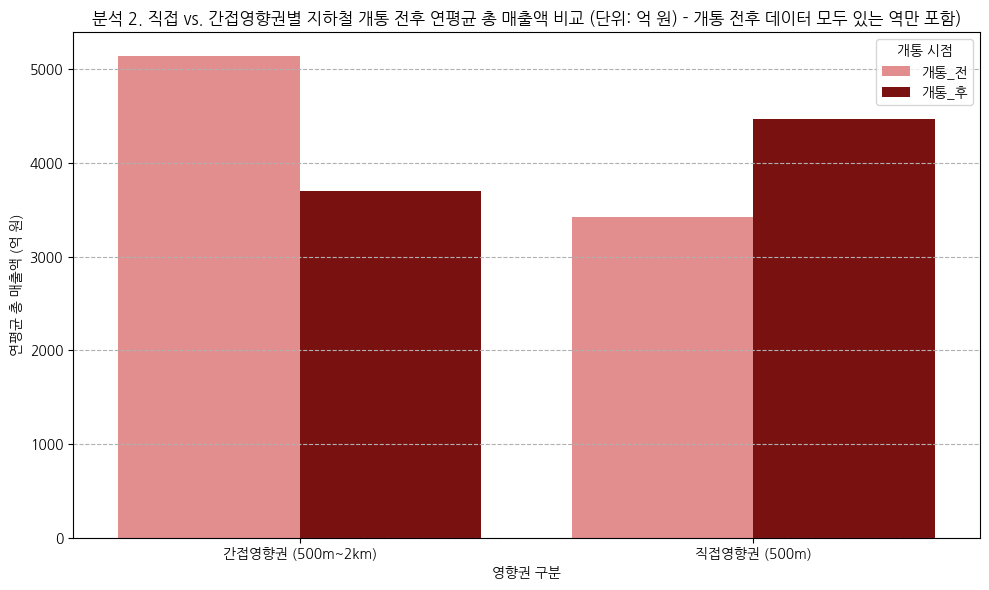

In [30]:
print("\n" + "="*50)
print("3.1. 분석 2 수정: 직접 vs. 간접영향권별 연평균 매출 활성화 비교 (개통 전후 데이터 모두 있는 역만 포함)")
print("="*50)

# 1. 개통 전후 데이터가 모두 있는 역만 포함하는 DataFrame 생성 (Analysis 1에서 계산된 complete_stations_avg 재사용)
# 이전에 계산된 complete_stations (총 매출액 기준) 대신, 연평균 매출액 기준으로 이미 필터링된 complete_stations_avg를 사용합니다.
df_filtered_for_analysis2 = df[df['역이름'].isin(complete_stations_avg)].copy()

# 2. '영향권_구분', '기준연도', '개통_전후'별 매출액 합산
df_annual_impact_revenue = df_filtered_for_analysis2.groupby(['영향권_구분', '기준연도', '개통_전후'])['매출금액_억'].sum().reset_index()

# 3. 각 '영향권_구분', '개통_전후' 조합에 대한 연평균 매출액 계산
df_agg_impact_avg_annual = df_annual_impact_revenue.groupby(['영향권_구분', '개통_전후'])['매출금액_억'].mean().reset_index()

# 4. '기타' 값 필터링
df_agg_impact_avg_annual_filtered = df_agg_impact_avg_annual[df_agg_impact_avg_annual['영향권_구분'] != '기타']

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_agg_impact_avg_annual_filtered,
    x='영향권_구분',
    y='매출금액_억',
    hue='개통_전후',
    palette={'개통_전': 'lightcoral', '개통_후': 'darkred'}
)
plt.title('분석 2. 직접 vs. 간접영향권별 지하철 개통 전후 연평균 총 매출액 비교 (단위: 억 원) - 개통 전후 데이터 모두 있는 역만 포함)')
plt.xlabel('영향권 구분')
plt.ylabel('연평균 총 매출액 (억 원)')
plt.legend(title='개통 시점')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


4.2. 분석 3 추가: 영향권별 업종별 지하철 개통에 따른 연평균 경제 활성화 정도의 차이

==================== 직접영향권 (500m) ====================


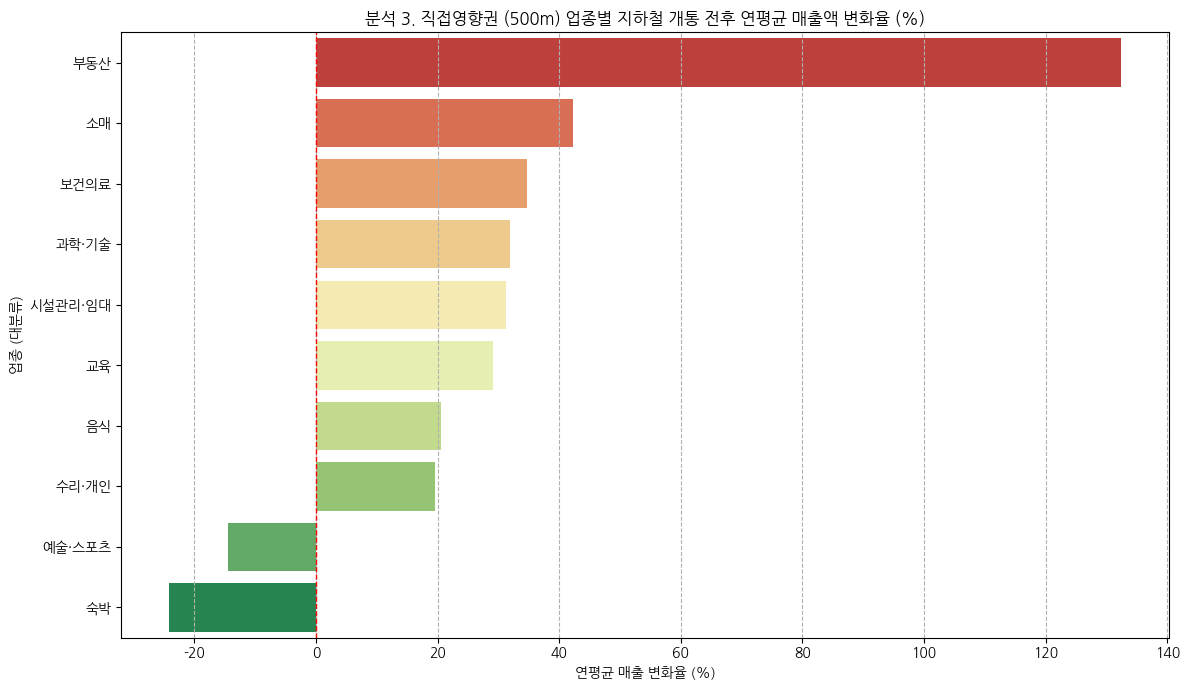


직접영향권 (500m) 업종별 연평균 매출 변화율 (활성화 O/X):
| 대분류        |   매출_변화율(%) |
|:--------------|-----------------:|
| 부동산        |           132.41 |
| 소매          |            42.23 |
| 보건의료      |            34.67 |
| 과학·기술     |            31.93 |
| 시설관리·임대 |            31.27 |
| 교육          |            29.14 |
| 음식          |            20.57 |
| 수리·개인     |            19.63 |
| 예술·스포츠   |           -14.54 |
| 숙박          |           -24.19 |

==================== 간접영향권 (500m~2km) ====================


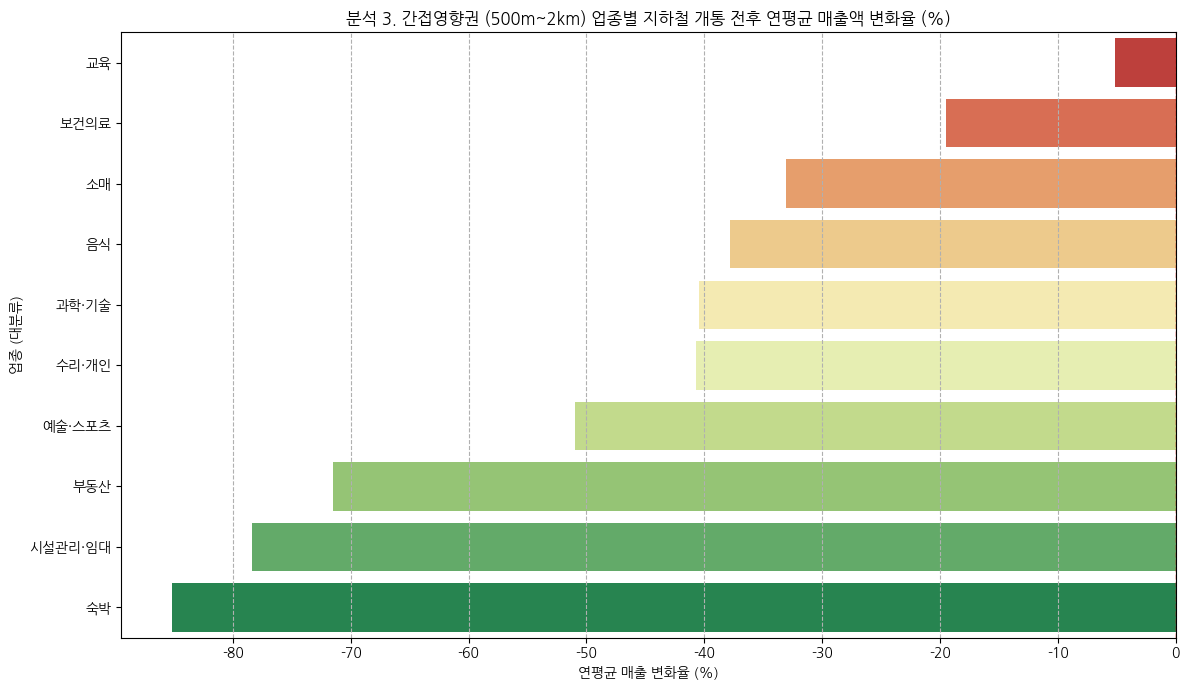


간접영향권 (500m~2km) 업종별 연평균 매출 변화율 (활성화 O/X):
| 대분류        |   매출_변화율(%) |
|:--------------|-----------------:|
| 교육          |            -5.13 |
| 보건의료      |           -19.49 |
| 소매          |           -33.05 |
| 음식          |           -37.82 |
| 과학·기술     |           -40.45 |
| 수리·개인     |           -40.7  |
| 예술·스포츠   |           -50.97 |
| 부동산        |           -71.46 |
| 시설관리·임대 |           -78.39 |
| 숙박          |           -85.19 |


In [34]:
print("\n" + "="*50)
print("4.2. 분석 3 추가: 영향권별 업종별 지하철 개통에 따른 연평균 경제 활성화 정도의 차이")
print("="*50)

impact_zones = ['직접영향권 (500m)', '간접영향권 (500m~2km)']

for zone in impact_zones:
    print(f"\n{'='*20} {zone} {'='*20}")

    # 해당 영향권 데이터 필터링
    df_zone = df[df['영향권_구분'] == zone].copy()

    # 1. '대분류', '기준연도', '개통_전후'별 매출액 합산
    df_annual_sector_revenue_zone = df_zone.groupby(['대분류', '기준연도', '개통_전후'])['매출금액_억'].sum().reset_index()

    # 2. 각 '대분류', '개통_전후' 조합에 대한 연평균 매출액 계산
    df_agg_sector_avg_annual_zone = df_annual_sector_revenue_zone.groupby(['대분류', '개통_전후'])['매출금액_억'].mean().reset_index()

    # 3. 개통 전후 데이터를 Unstack하여 비교 준비
    df_sector_agg_avg_annual_zone = df_agg_sector_avg_annual_zone.pivot(
        index='대분류', columns='개통_전후', values='매출금액_억'
    ).fillna(0).reset_index()
    df_sector_agg_avg_annual_zone.columns.name = None # Unstack으로 생긴 이름 제거

    # 4. 변화율 계산: (개통_후 - 개통_전) / 개통_전 * 100
    df_sector_agg_avg_annual_zone['매출_변화율(%)'] = df_sector_agg_avg_annual_zone.apply(
        lambda row: ((row['개통_후'] - row['개통_전']) / row['개통_전']) * 100 if row['개통_전'] != 0 else 0,
        axis=1
    )

    # 5. 변화율 기준으로 정렬
    df_sector_agg_avg_annual_sorted_zone = df_sector_agg_avg_annual_zone.sort_values(by='매출_변화율(%)', ascending=False)

    # 시각화
    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=df_sector_agg_avg_annual_sorted_zone,
        x='매출_변화율(%)',
        y='대분류',
        hue='대분류', # Assign y variable to hue as per FutureWarning
        palette=sns.color_palette("RdYlGn", len(df_sector_agg_avg_annual_sorted_zone)),
        legend=False # Set legend to False as per FutureWarning
    )
    plt.title(f'분석 3. {zone} 업종별 지하철 개통 전후 연평균 매출액 변화율 (%)')
    plt.xlabel('연평균 매출 변화율 (%)')
    plt.ylabel('업종 (대분류)')
    plt.axvline(0, color='red', linestyle='--', linewidth=1)
    plt.grid(axis='x', linestyle='--')
    plt.tight_layout()
    plt.show()

    # 변화율 출력
    print(f"\n{zone} 업종별 연평균 매출 변화율 (활성화 O/X):")
    print(df_sector_agg_avg_annual_sorted_zone[['대분류', '매출_변화율(%)']].round(2).to_markdown(index=False))


4.1. 분석 3 수정: 업종별 지하철 개통에 따른 연평균 경제 활성화 정도의 차이


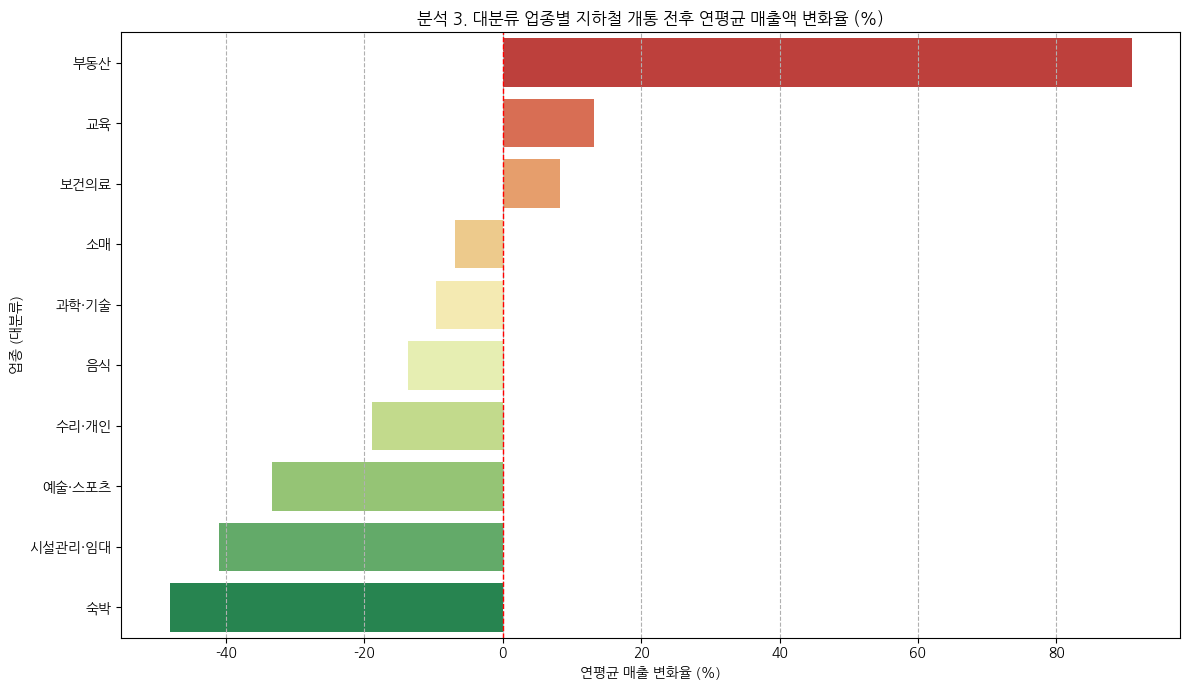


업종별 연평균 매출 변화율 (활성화 O/X):
| 대분류        |   매출_변화율(%) |
|:--------------|-----------------:|
| 부동산        |            90.92 |
| 교육          |            13.21 |
| 보건의료      |             8.23 |
| 소매          |            -6.85 |
| 과학·기술     |            -9.59 |
| 음식          |           -13.75 |
| 수리·개인     |           -18.94 |
| 예술·스포츠   |           -33.37 |
| 시설관리·임대 |           -40.99 |
| 숙박          |           -48.16 |


In [33]:
print("\n" + "="*50)
print("4.1. 분석 3 수정: 업종별 지하철 개통에 따른 연평균 경제 활성화 정도의 차이")
print("="*50)

# 1. '대분류', '기준연도', '개통_전후'별 매출액 합산
df_annual_sector_revenue = df.groupby(['대분류', '기준연도', '개통_전후'])['매출금액_억'].sum().reset_index()

# 2. 각 '대분류', '개통_전후' 조합에 대한 연평균 매출액 계산
df_agg_sector_avg_annual = df_annual_sector_revenue.groupby(['대분류', '개통_전후'])['매출금액_억'].mean().reset_index()

# 3. 개통 전후 데이터를 Unstack하여 비교 준비
df_sector_agg_avg_annual = df_agg_sector_avg_annual.pivot(index='대분류', columns='개통_전후', values='매출금액_억').fillna(0).reset_index()
df_sector_agg_avg_annual.columns.name = None # Unstack으로 생긴 이름 제거

# 4. 변화율 계산: (개통_후 - 개통_전) / 개통_전 * 100
# '개통_전'이 0인 경우를 처리하여 ZeroDivisionError 방지
df_sector_agg_avg_annual['매출_변화율(%)'] = df_sector_agg_avg_annual.apply(
    lambda row: ((row['개통_후'] - row['개통_전']) / row['개통_전']) * 100 if row['개통_전'] != 0 else 0,
    axis=1
)

# 5. 변화율 기준으로 정렬
df_sector_agg_avg_annual_sorted = df_sector_agg_avg_annual.sort_values(by='매출_변화율(%)', ascending=False)

# 시각화
plt.figure(figsize=(12, 7))
sns.barplot(
    data=df_sector_agg_avg_annual_sorted,
    x='매출_변화율(%)',
    y='대분류',
    hue='대분류', # Assign y variable to hue as per FutureWarning
    palette=sns.color_palette("RdYlGn", len(df_sector_agg_avg_annual_sorted)), # 활성화 O/X 색상 구분
    legend=False # Set legend to False as per FutureWarning
)
plt.title('분석 3. 대분류 업종별 지하철 개통 전후 연평균 매출액 변화율 (%)')
plt.xlabel('연평균 매출 변화율 (%)')
plt.ylabel('업종 (대분류)')
plt.axvline(0, color='red', linestyle='--', linewidth=1) # 0% 기준선
plt.grid(axis='x', linestyle='--')
plt.tight_layout()
plt.show()

# 변화율 출력 (활성화 O/X 확인)
print("\n업종별 연평균 매출 변화율 (활성화 O/X):")
print(df_sector_agg_avg_annual_sorted[['대분류', '매출_변화율(%)']].round(2).to_markdown(index=False))

In [ ]:
# '중앙역'과 '성포역' 데이터를 df에서 제외합니다.
df_original_len = len(df)
df = df[~df['역이름'].isin(['중앙역', '성포역'])]
print(f"'중앙역'과 '성포역' 데이터를 제외했습니다. 원래 데이터 수: {df_original_len}, 제외 후 데이터 수: {len(df)}")

# 변경된 df의 head를 확인하여 데이터 제외 여부를 확인합니다.
display(df.head())